In [1]:
# !pip uninstall prophet
# !pip install prophet

In [12]:
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
import itertools

In [5]:
df = pd.read_csv('/Users/kendrickchuah/code/reedyoh/InvestoInsight/raw_data/sorted_feature_matrix.csv')

df.head()

,Unnamed: 0,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma
0,69,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,0.519859,0.194486
1,138,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,0.697481,0.080405
2,207,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,0.399009,0.249330
3,276,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,0.580027,0.096485
4,345,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,0.000015,0.999982


In [6]:
stock_data = df.rename(columns={'Date': 'ds', 'stock_price': 'y'})
stock_data = stock_data.reset_index()
stock_data['ds'] = pd.to_datetime(stock_data['ds'])

In [7]:
# Sort your DataFrame by the datetime column
df = stock_data.sort_values(by='ds')

# Calculate the cut-off point for splitting
cutoff_date = df['ds'].max() - pd.DateOffset(months=12)

# Split the data into training and test sets
train_data = df[df['ds'] <= cutoff_date]
test_data = df[(df['ds'] > cutoff_date) & (df['ds'] <= cutoff_date + pd.DateOffset(months=12))]

In [6]:
train_data.head()

,index,Unnamed: 0,ds,Dividend,Volume,y,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma
0,0,69,2018-01-31,0.000000,5.315047e+06,51.919825,1.41,4500.182,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,0.519859,0.194486
304,304,23758,2018-01-31,0.770000,3.153467e+06,39.549498,1.41,4500.182,OKE,1.692314,0.761522,0.047087,0.563877,0.135708,0.540405,0.000004,0.999971,0.000025
303,303,23652,2018-01-31,0.000000,9.646500e+05,92.365229,1.41,4500.182,ODFL,0.333360,2.118108,0.066277,3.251481,0.166119,-0.100032,0.217593,0.670863,0.111544
302,302,23583,2018-01-31,0.212209,2.919831e+06,38.530611,1.41,4500.182,O,0.961939,0.335424,0.012897,0.028913,0.135766,-0.750594,0.001090,0.998810,0.000100
301,301,23445,2018-01-31,0.000000,2.373877e+06,15.401748,1.41,4500.182,NWSA,0.758773,0.172975,0.010906,1.151199,1.389065,3.453608,0.053748,0.925971,0.020281


Test on 1 stock

In [13]:
ticker_data = train_data.loc[train_data['Tickers'] == "AAPL"]

In [7]:
# Initialize and fit the Prophet model for the current ticker
model = Prophet()
model.fit(ticker_data)

# Create a future DataFrame for predictions
future = model.make_future_dataframe(periods=12, freq='M')  # Adjust as needed

# Make predictions for the current ticker
forecast = model.predict(future)
forecast  # Add a 'ticker' column to identify the forecasts

22:14:39 - cmdstanpy - INFO - Chain [1] start processing


22:14:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-31,29.269890,27.551524,52.148856,29.269890,29.269890,9.987428,9.987428,9.987428,9.987428,9.987428,9.987428,0.0,0.0,0.0,39.257318
1,2018-02-28,30.658167,23.754864,50.465383,30.658167,30.658167,6.057066,6.057066,6.057066,6.057066,6.057066,6.057066,0.0,0.0,0.0,36.715233
2,2018-03-31,32.195188,20.183031,46.341593,32.195188,32.195188,1.083507,1.083507,1.083507,1.083507,1.083507,1.083507,0.0,0.0,0.0,33.278695
3,2018-04-30,33.682628,22.408988,47.330212,33.682628,33.682628,1.108183,1.108183,1.108183,1.108183,1.108183,1.108183,0.0,0.0,0.0,34.790810
4,2018-05-31,35.219649,19.062169,44.780807,35.219649,35.219649,-3.389366,-3.389366,-3.389366,-3.389366,-3.389366,-3.389366,0.0,0.0,0.0,31.830283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2023-05-31,198.963205,182.849484,208.660995,198.140409,199.863588,-3.139843,-3.139843,-3.139843,-3.139843,-3.139843,-3.139843,0.0,0.0,0.0,195.823362
65,2023-06-30,202.053085,181.780876,206.164711,201.007615,203.145174,-8.191873,-8.191873,-8.191873,-8.191873,-8.191873,-8.191873,0.0,0.0,0.0,193.861212
66,2023-07-31,205.245961,187.844463,213.549733,204.022307,206.555196,-4.656296,-4.656296,-4.656296,-4.656296,-4.656296,-4.656296,0.0,0.0,0.0,200.589665
67,2023-08-31,208.438837,197.338032,223.149687,207.030797,209.961560,1.555031,1.555031,1.555031,1.555031,1.555031,1.555031,0.0,0.0,0.0,209.993868


In [8]:
ticker_data.shape

(57, 18)

/Users/kendrickchuah/.pyenv/versions/3.10.6/envs/InvestoInsight/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kendrickchuah/.pyenv/versions/3.10.6/envs/InvestoInsight/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


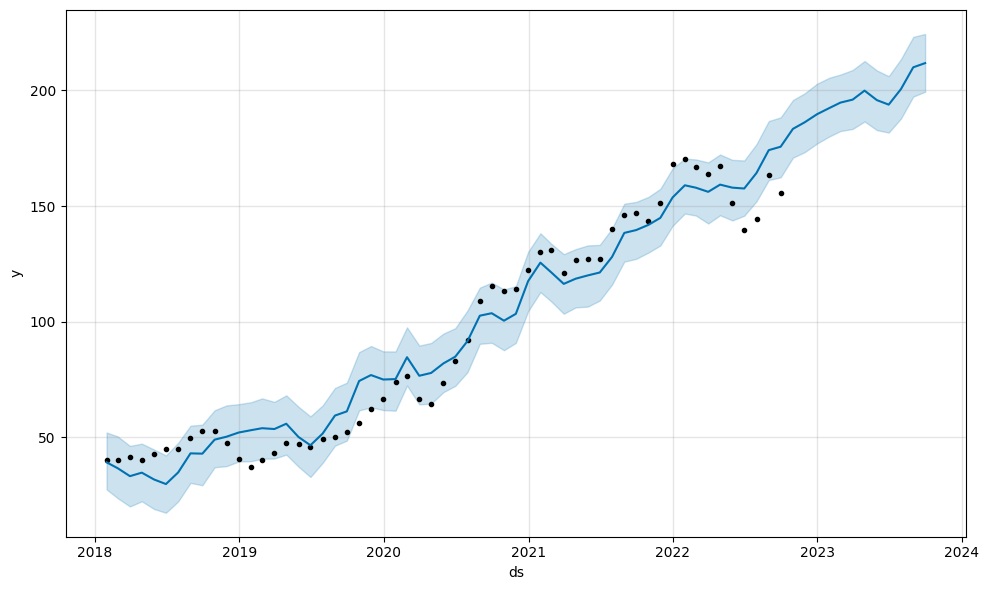

In [9]:
# for symbol in all_forecasts['symbol']:
#     fig = model.plot(all_forecasts['symbol'] == symbol)

fig = model.plot(forecast)

In [10]:
aapl = df[df['Tickers']== "AAPL"]
aapl

,index,Unnamed: 0,ds,Dividend,Volume,y,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma
1,1,138,2018-01-31,0.0000,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,0.697481,8.040471e-02
448,448,139,2018-02-28,0.1575,1.795523e+08,40.275178,1.42,4549.064667,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.237099,0.657282,1.056192e-01
906,906,140,2018-03-31,0.0000,1.408173e+08,41.485005,1.51,4597.947333,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.217146,0.637216,1.456380e-01
1372,1372,141,2018-04-30,0.0000,1.329808e+08,40.385733,1.69,4646.830000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.188215,0.633217,1.785686e-01
1838,1838,142,2018-05-31,0.1825,1.234549e+08,42.894046,1.70,4661.188333,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.257901,0.637290,1.048093e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30520,30520,202,2023-05-31,0.2400,5.633145e+07,170.569296,5.06,5105.025000,AAPL,4.485512,1.359489,0.349863,0.908233,0.720599,6.474396,0.000005,0.997847,2.148082e-03
31002,31002,203,2023-06-30,0.0000,5.990656e+07,180.404719,5.08,5105.025000,AAPL,4.558582,1.270525,0.329844,0.922737,0.727719,6.173854,0.249997,0.749991,1.255915e-05
31484,31484,204,2023-07-31,0.0000,5.990656e+07,180.404719,5.08,5105.025000,AAPL,4.558582,1.270525,0.329844,0.922737,0.727719,6.173854,0.500628,0.498846,5.262758e-04
31965,31965,205,2023-08-31,0.0000,5.990656e+07,180.404719,5.08,5105.025000,AAPL,4.558582,1.270525,0.329844,0.922737,0.727719,6.173854,0.502358,0.497387,2.558414e-04


In [11]:
mae = mean_absolute_error(aapl['y'], forecast['yhat'])
mae

13.457952503389944

In [12]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: SMAPE score.
    """
    assert len(y_true) == len(y_pred), "Input sequences must have the same length."

    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0

    smape_score = np.mean(numerator / denominator) * 100.0

    return smape_score

# Example usage:
y_true = aapl['y']  # Actual values
y_pred = forecast['yhat']  # Predicted values

smape_score = smape(y_true, y_pred)
print(f"SMAPE: {smape_score:.2f}%")


SMAPE: 9.25%


In [13]:
rmse = sqrt(mean_squared_error(aapl['y'], forecast['yhat']))
rmse

18.321353371287547

Actual application to all tickers in S&P500

All unique tickers in dataset

In [9]:
tickers = df['Tickers'].unique()
tickers[0:10]

array(['AAL', 'OKE', 'ODFL', 'O', 'NWSA', 'NWS', 'NWL', 'NVR', 'NVDA',
       'NUE'], dtype=object)

In [16]:
# Create an empty DataFrame to store all forecasts
combined_forecasts = pd.DataFrame()

In [17]:
# Loop through each unique 'ticker'
for ticker in tickers:
    # Filter data for the current ticker
    stock_data = train_data[train_data['Tickers'] == ticker]
    
    # Initialize and fit the Prophet model
    model2 = Prophet()
    model2.fit(stock_data)
    
    # Make predictions for the next 12 months
    future = model2.make_future_dataframe(periods=12, freq='M')
    forecast = model2.predict(future)
    
    # #Filter original data for specific ticker (use for RMSE calculation)
    # ticker_df = df.loc[df['Tickers'] == ticker]

    # Add a column 'ticker' to the forecast DataFrame to indicate the stock ticker
    forecast['ticker'] = ticker
    
    # Concatenate the current forecast with the combined_forecasts DataFrame
    combined_forecasts = pd.concat([combined_forecasts, forecast])   

22:14:40 - cmdstanpy - INFO - Chain [1] start processing


22:14:40 - cmdstanpy - INFO - Chain [1] done processing
22:14:40 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:42 - cmdstanpy - INFO - Chain [1] start processing
22:14:42 - cmdstanpy - INFO - Chain [1] done processing
22:14:42 - cmdstanpy - INFO - Chain [1] start processing
22:14:42 - cmdstanpy - INFO - Chain [1] done processing
22:14:42 - cmdstanpy - INFO - Chain [1] start processing
22:14:42 - cmdstanpy - INFO - Chain [1] done processing
22:14:42 - cmdstanpy - INFO - Chain [1] start processing
22:14:43 - cmdstanpy - INFO - Chain [1] done processing
22:14:43 - cmdstanpy - INFO - Chain [1] 

In [18]:
combined_forecasts.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ticker
0,2018-01-31,47.042737,44.472374,52.843666,47.042737,47.042737,1.664252,1.664252,1.664252,1.664252,1.664252,1.664252,0.0,0.0,0.0,48.706988,AAL
1,2018-02-28,46.117319,43.226170,51.961595,46.117319,46.117319,1.497352,1.497352,1.497352,1.497352,1.497352,1.497352,0.0,0.0,0.0,47.614670,AAL
2,2018-03-31,45.092749,41.939237,50.214469,45.092749,45.092749,1.006878,1.006878,1.006878,1.006878,1.006878,1.006878,0.0,0.0,0.0,46.099626,AAL
3,2018-04-30,44.101229,40.881271,49.057391,44.101229,44.101229,0.553301,0.553301,0.553301,0.553301,0.553301,0.553301,0.0,0.0,0.0,44.654531,AAL
4,2018-05-31,43.076660,39.054893,47.337529,43.076660,43.076660,0.114110,0.114110,0.114110,0.114110,0.114110,0.114110,0.0,0.0,0.0,43.190770,AAL


In [19]:
mmm = combined_forecasts[combined_forecasts['ticker']== "MMM"]
mmm

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ticker
0,2018-01-31,163.684136,157.089875,197.918387,163.684136,163.684136,14.350739,14.350739,14.350739,14.350739,14.350739,14.350739,0.0,0.0,0.0,178.034875,MMM
1,2018-02-28,163.259342,153.844033,194.029463,163.259342,163.259342,10.538612,10.538612,10.538612,10.538612,10.538612,10.538612,0.0,0.0,0.0,173.797954,MMM
2,2018-03-31,162.789034,151.154739,190.572993,162.789034,162.789034,7.791861,7.791861,7.791861,7.791861,7.791861,7.791861,0.0,0.0,0.0,170.580895,MMM
3,2018-04-30,162.333897,148.817850,190.833590,162.333897,162.333897,7.800833,7.800833,7.800833,7.800833,7.800833,7.800833,0.0,0.0,0.0,170.134730,MMM
4,2018-05-31,161.863589,142.652429,182.810995,161.863589,161.863589,0.497526,0.497526,0.497526,0.497526,0.497526,0.497526,0.0,0.0,0.0,162.361115,MMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2023-05-31,134.934271,112.238127,154.675617,134.922553,134.945613,-2.626830,-2.626830,-2.626830,-2.626830,-2.626830,-2.626830,0.0,0.0,0.0,132.307441,MMM
65,2023-06-30,134.497523,107.483529,147.510886,134.483498,134.511153,-7.483141,-7.483141,-7.483141,-7.483141,-7.483141,-7.483141,0.0,0.0,0.0,127.014382,MMM
66,2023-07-31,134.046217,113.236013,153.696069,134.030046,134.062585,-1.014206,-1.014206,-1.014206,-1.014206,-1.014206,-1.014206,0.0,0.0,0.0,133.032011,MMM
67,2023-08-31,133.594910,116.779812,158.335593,133.576431,133.613813,4.356126,4.356126,4.356126,4.356126,4.356126,4.356126,0.0,0.0,0.0,137.951036,MMM


Hyperparameter Tuning

In [ ]:
param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode' : ['additive', 'multiplicative'],
        'changepoint_range': [0.85, 0.90, 0.95]
    }

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(ticker_data)  # Fit model with given params
    df_cv = cross_validation(m,  initial='2600', period='100 days', horizon = '7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
#print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

20:46:55 - cmdstanpy - INFO - Chain [1] start processing


20:46:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:46:55 - cmdstanpy - INFO - Chain [1] start processing
20:46:55 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 10/14 [00:43<00:17,  4.37s/it]
20:46:55 - cmdstanpy - INFO - Chain [1] start processing
20:46:55 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing
20:46:57 - cmdstanpy - INFO - Chain [1] start processing
20:46:57 - cmdstanpy - INFO - Chain [1] done processing
2

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


In [ ]:
min(rmses)

5.848926483760698

Mass Evaluation

In [13]:
# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.85, 0.90, 0.95]
}

# Initialize an empty DataFrame to store the results
results = []

# Loop through each ticker
for ticker in tickers:
    # Load data for the current ticker (you should replace this with your data loading code)
    ticker_data = train_data[train_data['Tickers'] == ticker]

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each parameter set here

    # Use cross-validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(ticker_data)
        df_cv = cross_validation(m, initial='2600', period='100 days', horizon='7 days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    # Find the best parameters for this ticker
    best_params = all_params[np.argmin(rmses)]

    # Store the results in the DataFrame
    results.append({'ticker': ticker, 'best_params': best_params})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results or save them to a CSV file
print(results_df)
results_df.to_csv('parameter_tuning_results.csv', index=False)

17:08:25 - cmdstanpy - INFO - Chain [1] start processing
17:08:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/14 [00:00<?, ?it/s]17:08:26 - cmdstanpy - INFO - Chain [1] start processing
17:08:26 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:02,  5.63it/s]17:08:26 - cmdstanpy - INFO - Chain [1] start processing
17:08:26 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:00<00:02,  4.03it/s]17:08:26 - cmdstanpy - INFO - Chain [1] start processing
17:08:26 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:00<00:02,  3.95it/s]17:08:26 - cmdstanpy - INFO - Chain [1] start processing
17:08:26 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:01<00:02,  3.86it/s]17:08:27 - cmdstanpy - INFO - Chain [1] start processing
17:08:27 - cmdstanpy - INFO - Chain [1] done process

Evaluating Hyperparameter Tuning Updated Model

In [26]:
ticker_data2 = train_data.loc[train_data['Tickers'] == "AAPL"]

In [28]:
# Initialize and fit the Prophet model for the current ticker
model3 = Prophet(changepoint_prior_scale = 0.5, 
                seasonality_prior_scale = 0.1, 
                seasonality_mode = 'additive', 
                changepoint_range = 0.95)
model3.fit(ticker_data2)

# Create a future DataFrame for predictions
future3 = model3.make_future_dataframe(periods=12, freq='M')  # Adjust as needed

# Make predictions for the current ticker
forecast3 = model3.predict(future3)
forecast3  # Add a 'ticker' column to identify the forecasts

22:03:12 - cmdstanpy - INFO - Chain [1] start processing


22:03:13 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-31,37.783034,37.695247,47.182470,37.783034,37.783034,4.584574,4.584574,4.584574,4.584574,4.584574,4.584574,0.0,0.0,0.0,42.367608
1,2018-02-28,39.740245,36.833398,45.849477,39.740245,39.740245,1.626711,1.626711,1.626711,1.626711,1.626711,1.626711,0.0,0.0,0.0,41.366956
2,2018-03-31,41.907157,34.197131,43.948309,41.907157,41.907157,-2.607652,-2.607652,-2.607652,-2.607652,-2.607652,-2.607652,0.0,0.0,0.0,39.299505
3,2018-04-30,44.004169,37.737330,46.990405,44.004169,44.004169,-1.552071,-1.552071,-1.552071,-1.552071,-1.552071,-1.552071,0.0,0.0,0.0,42.452097
4,2018-05-31,46.171081,37.024518,46.432650,46.171081,46.171081,-4.438634,-4.438634,-4.438634,-4.438634,-4.438634,-4.438634,0.0,0.0,0.0,41.732447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2023-05-31,144.386425,123.468709,158.401324,129.427614,162.321845,-4.120066,-4.120066,-4.120066,-4.120066,-4.120066,-4.120066,0.0,0.0,0.0,140.266360
65,2023-06-30,143.406393,116.176130,158.264138,124.884174,163.983432,-7.725919,-7.725919,-7.725919,-7.725919,-7.725919,-7.725919,0.0,0.0,0.0,135.680474
66,2023-07-31,142.393692,114.826890,162.031494,120.178375,166.587141,-4.474357,-4.474357,-4.474357,-4.474357,-4.474357,-4.474357,0.0,0.0,0.0,137.919335
67,2023-08-31,141.380991,118.256685,172.641307,115.202347,169.653622,2.494592,2.494592,2.494592,2.494592,2.494592,2.494592,0.0,0.0,0.0,143.875583


In [29]:
ticker_data2.shape

(57, 18)

/Users/kendrickchuah/.pyenv/versions/3.10.6/envs/InvestoInsight/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kendrickchuah/.pyenv/versions/3.10.6/envs/InvestoInsight/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


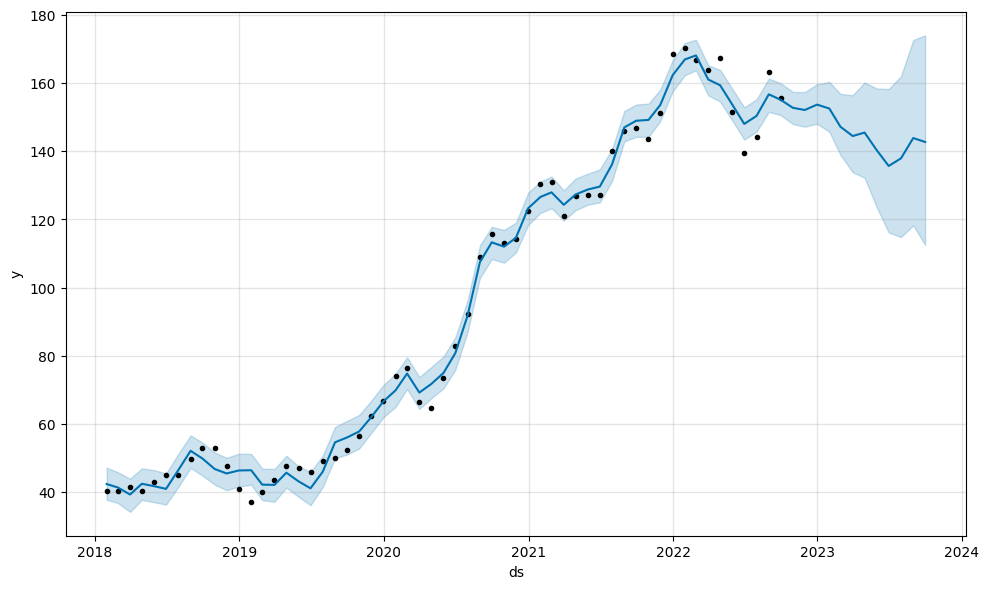

In [30]:
# for symbol in all_forecasts['symbol']:
#     fig = model.plot(all_forecasts['symbol'] == symbol)

fig = model3.plot(forecast3)

In [31]:
aapl = df[df['Tickers']== "AAPL"]
aapl

,index,Unnamed: 0,ds,Dividend,Volume,y,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma
1,1,138,2018-01-31,0.0000,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,0.697481,8.040471e-02
448,448,139,2018-02-28,0.1575,1.795523e+08,40.275178,1.42,4549.064667,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.237099,0.657282,1.056192e-01
906,906,140,2018-03-31,0.0000,1.408173e+08,41.485005,1.51,4597.947333,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.217146,0.637216,1.456380e-01
1372,1372,141,2018-04-30,0.0000,1.329808e+08,40.385733,1.69,4646.830000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.188215,0.633217,1.785686e-01
1838,1838,142,2018-05-31,0.1825,1.234549e+08,42.894046,1.70,4661.188333,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.257901,0.637290,1.048093e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30520,30520,202,2023-05-31,0.2400,5.633145e+07,170.569296,5.06,5105.025000,AAPL,4.485512,1.359489,0.349863,0.908233,0.720599,6.474396,0.000005,0.997847,2.148082e-03
31002,31002,203,2023-06-30,0.0000,5.990656e+07,180.404719,5.08,5105.025000,AAPL,4.558582,1.270525,0.329844,0.922737,0.727719,6.173854,0.249997,0.749991,1.255915e-05
31484,31484,204,2023-07-31,0.0000,5.990656e+07,180.404719,5.08,5105.025000,AAPL,4.558582,1.270525,0.329844,0.922737,0.727719,6.173854,0.500628,0.498846,5.262758e-04
31965,31965,205,2023-08-31,0.0000,5.990656e+07,180.404719,5.08,5105.025000,AAPL,4.558582,1.270525,0.329844,0.922737,0.727719,6.173854,0.502358,0.497387,2.558414e-04


In [32]:
mae = mean_absolute_error(aapl['y'], forecast3['yhat'])
mae

6.290150140464746

In [33]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: SMAPE score.
    """
    assert len(y_true) == len(y_pred), "Input sequences must have the same length."

    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0

    smape_score = np.mean(numerator / denominator) * 100.0

    return smape_score

# Example usage:
y_true = aapl['y']  # Actual values
y_pred = forecast3['yhat']  # Predicted values

smape_score = smape(y_true, y_pred)
print(f"SMAPE: {smape_score:.2f}%")


SMAPE: 2.67%


After Hyperparameter Tuning

In [17]:
tickers = df['Tickers'].unique()
tickers[0:10]

array(['AAL', 'OKE', 'ODFL', 'O', 'NWSA', 'NWS', 'NWL', 'NVR', 'NVDA',
       'NUE'], dtype=object)

In [19]:
# Create an empty DataFrame to store all forecasts
combined_forecasts2 = pd.DataFrame()

In [20]:
# Loop through each unique 'ticker'
for ticker in tickers:
    # Filter data for the current ticker
    stock_data = train_data[train_data['Tickers'] == ticker]
    
    # Initialize and fit the Prophet model
    model2 = Prophet(changepoint_prior_scale = 0.5, 
                     seasonality_prior_scale = 0.1, 
                     seasonality_mode = 'additive', 
                     changepoint_range = 0.95)
    model2.fit(stock_data)
    
    # Make predictions for the next 12 months
    future2 = model2.make_future_dataframe(periods=12, freq='M')
    forecast2 = model2.predict(future2)
    
    # #Filter original data for specific ticker (use for RMSE calculation)
    # ticker_df = df.loc[df['Tickers'] == ticker]

    # Add a column 'ticker' to the forecast DataFrame to indicate the stock ticker
    forecast2['ticker'] = ticker
    
    # Concatenate the current forecast with the combined_forecasts DataFrame
    combined_forecasts2 = pd.concat([combined_forecasts2, forecast2])
    

21:47:27 - cmdstanpy - INFO - Chain [1] start processing


21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing
21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:32 - cmdstanpy - INFO - Chain [1] 

In [21]:
combined_forecasts2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ticker
0,2018-01-31,53.220936,51.929741,54.167531,53.220936,53.220936,-0.187528,-0.187528,-0.187528,-0.187528,-0.187528,-0.187528,0.0,0.0,0.0,53.033409,AAL
1,2018-02-28,50.945566,50.296998,52.616311,50.945566,50.945566,0.532731,0.532731,0.532731,0.532731,0.532731,0.532731,0.0,0.0,0.0,51.478297,AAL
2,2018-03-31,48.426407,47.416728,49.768505,48.426407,48.426407,0.176897,0.176897,0.176897,0.176897,0.176897,0.176897,0.0,0.0,0.0,48.603304,AAL
3,2018-04-30,45.987555,44.945782,47.204826,45.987555,45.987555,0.038092,0.038092,0.038092,0.038092,0.038092,0.038092,0.0,0.0,0.0,46.025647,AAL
4,2018-05-31,43.467408,42.702894,44.927101,43.467408,43.467408,0.320853,0.320853,0.320853,0.320853,0.320853,0.320853,0.0,0.0,0.0,43.788261,AAL


In [23]:
mmm = combined_forecasts2[combined_forecasts2['ticker']== "MMM"]
mmm

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ticker
0,2018-01-31,195.119413,191.974283,203.621042,195.119413,195.119413,2.703795,2.703795,2.703795,2.703795,2.703795,2.703795,0.0,0.0,0.0,197.823209,MMM
1,2018-02-28,189.762541,185.026072,196.306541,189.762541,189.762541,0.975118,0.975118,0.975118,0.975118,0.975118,0.975118,0.0,0.0,0.0,190.737660,MMM
2,2018-03-31,183.831719,176.919791,188.328433,183.831719,183.831719,-1.183869,-1.183869,-1.183869,-1.183869,-1.183869,-1.183869,0.0,0.0,0.0,182.647850,MMM
3,2018-04-30,178.092213,172.344963,183.910847,178.092213,178.092213,-0.053399,-0.053399,-0.053399,-0.053399,-0.053399,-0.053399,0.0,0.0,0.0,178.038815,MMM
4,2018-05-31,172.161391,162.238109,173.855570,172.161391,172.161391,-3.881225,-3.881225,-3.881225,-3.881225,-3.881225,-3.881225,0.0,0.0,0.0,168.280166,MMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2023-05-31,85.308665,61.800449,100.226546,67.858458,103.864592,-4.612093,-4.612093,-4.612093,-4.612093,-4.612093,-4.612093,0.0,0.0,0.0,80.696572,MMM
65,2023-06-30,81.038577,52.111210,97.814127,60.235172,103.552506,-6.138134,-6.138134,-6.138134,-6.138134,-6.138134,-6.138134,0.0,0.0,0.0,74.900443,MMM
66,2023-07-31,76.626153,49.326973,101.283464,52.005960,103.529656,-2.435010,-2.435010,-2.435010,-2.435010,-2.435010,-2.435010,0.0,0.0,0.0,74.191143,MMM
67,2023-08-31,72.213729,45.867187,107.866659,43.859139,103.201444,2.795719,2.795719,2.795719,2.795719,2.795719,2.795719,0.0,0.0,0.0,75.009448,MMM
